# Implementing connectome eigenmode construction by Laplacian spectral decomposition of the group level structural connectivity

---

In this particular implementation, a random-walk Laplacian is used. This alternative uses the transition probability matrix instead of the symmetric normalized adjacency.


### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


##### Connectome thresholding scripts

---


In [3]:
# Take sparse adjacency matrix and remove edges lower than a threshold
def threshold_connectome(connectome, threshold):
    connectome_thresholded = connectome.multiply(
        connectome > threshold
    )
    connectome_thresholded.eliminate_zeros()
    return connectome_thresholded

def report_density(connectome):
    print("Connectome density: {:.1f}%".format(100 * density(connectome)))

def binarized_connectome(connectome):
    return (connectome > 0).astype(float)
    
def connectome_strength(connectome):
    return np.array(connectome.sum(0))[0]


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [5]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [6]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
ax = np.concatenate([lx - expand, rx + expand])
ay = np.concatenate([ly, ry])
az = np.concatenate([lz, rz])
at = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
axyz = np.array([ax, ay, az]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [7]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(axyz.min(0) + axyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(ax.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(ax.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


##### Visualization functions

---

[Cerebro brain viewer](https://github.com/sina-mansour/Cerebro_Viewer) was used for visualization.


In [8]:
# Brain visualizations with Cerebro
from cerebro import cerebro_brain_utils as cbu
from cerebro import cerebro_brain_viewer as cbv

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

def plot_left_surface_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, view="L", show_colorbar=False, colorbar_format=None):
    try:
        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1,1,1,0), null_color=(0.9, 0.9, 0.9, 0.0), no_color=(.6, .6, .6, 1.))

        surface = 'midthickness'
        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none',
        )

        dscalar_layer = my_brain_viewer.add_cifti_dscalar_layer(
            dscalar_data=dscalar_data,
            colormap=colormap,
            clims=clims,
            opacity=0.95)

        ax.axis('off')
        camconf = my_brain_viewer.view_to_camera_config(view)
        camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

        if show_colorbar:
            cax = inset_axes(
                ax,
                width="50%",
                height="4%",
                loc="lower center",
                bbox_to_anchor=(-0., 0.0, 1., 1.),
                bbox_transform=ax.transAxes,
                borderpad=0,
            )
            cb = fig.colorbar(
                mpl.cm.ScalarMappable(
                    norm=mpl.colors.Normalize(vmin=clims[0], vmax=clims[1]),
                    cmap=colormap
                ),
                cax=cax,
                aspect=10,
                orientation='horizontal',
                format=colorbar_format,
            )
            cb.outline.set_visible(False)
            cb.ax.tick_params(labelsize=12)
            cb.ax.tick_params(length=0)

    finally:
        my_brain_viewer.viewer.window.destroy()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load high-resolution thickness data

---

In [9]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');


In [10]:
all_thickness_data.shape

(2473, 59412)

## Construct the connectome kernel

---

In [12]:
# copy group level connectome data from Dubinsky server
! scp "Dub:/data/netapp01/work/sina/lachlan/connectivity_probability_smoothed_8mm_thresholded_0.001.npz" \
      "/mountpoint/code/projects/normative_brain_charts/data/connectomes/"


connectivity_probability_smoothed_8mm_thresho 100% 3843MB  46.7MB/s   01:22    


In [11]:
# load group level connectome data
connectome = sparse.load_npz(f"{main_dir}/data/connectomes/connectivity_probability_smoothed_8mm_thresholded_0.001.npz")


In [12]:
# extract the cortical subgraph
cortical_connectome = connectome[:59412,:59412].copy()

In [38]:
# load the adjacency structure
local_adjacency_file = f'{main_dir}/data/templates/matrices/local_adjacency.npz'

local_adjacency = sparse.load_npz(ensure_dir(local_adjacency_file))


## Laplacian eigendecomposition

---

In [ ]:
# A function to compute the symmetric normalized adjacency
def symmetric_normalized_adj(adj):
    degree = sparse.diags(np.array(adj.sum(axis=0))[0])
    inverse_degree_square_root = degree.copy()
    inverse_degree_square_root.data **= -0.5
    SNA = (inverse_degree_square_root*adj*inverse_degree_square_root)
    return SNA


# a function performing a symmetric laplacian eigenmode decomposition over a sparse adjacency structure
def laplace_spectrum_rev(adj, k=100):
    # use shift invert mode
    lambdas, vectors = sparse.linalg.eigsh(
        symmetric_normalized_adj(adj),
        k=k+1,
        which="LM",
    )

    # convert to laplacian lambdas
    lambdas = 1 - lambdas
    lambda_idx = np.argsort(lambdas)
    lambdas = lambdas[lambda_idx]
    vectors = vectors[:, lambda_idx]
    return (lambdas, vectors)


In [31]:
# A function to compute the transition matrix from adjacency
def adj_to_transition(adj):
    degree = sparse.diags(np.array(adj.sum(axis=0))[0])
    inverse_degree = degree.copy()
    inverse_degree.data **= -1
    transition = (inverse_degree*adj)
    return transition


# a function performing a symmetric laplacian eigenmode decomposition over a sparse adjacency structure
def laplace_rw_spectrum_rev(adj, k=100):
    # use shift invert mode
    lambdas, vectors = sparse.linalg.eigsh(
        adj_to_transition(adj),
        k=k+1,
        which="LM",
    )

    # convert to laplacian lambdas
    lambdas = 1 - lambdas
    lambda_idx = np.argsort(lambdas)
    lambdas = lambdas[lambda_idx]
    vectors = vectors[:, lambda_idx]
    return (lambdas, vectors)


In [ ]:
%%time
cortical_connectome_eigenvalues, cortical_connectome_eigenvectors = laplace_rw_spectrum_rev((cortical_connectome + 1e-6*local_adjacency), 11000)
# cortical_connectome_eigenvalues, cortical_connectome_eigenvectors = laplace_spectrum_rev((cortical_connectome), 11000)


In [48]:
# store the computed kernel
write_np(cortical_connectome_eigenvalues, ensure_dir(f'{main_dir}/data/npy/rw_cortical_connectome_eigenvalues_cifti.npy'));
write_np(cortical_connectome_eigenvectors, ensure_dir(f'{main_dir}/data/npy/rw_cortical_connectome_eigenvectors_cifti.npy'));


In [29]:
cortical_connectome_eigenvectors.shape

(59412, 11001)

In [31]:
# ensure correctness by validating that all components are vectors of unit norm
np.linalg.norm(cortical_connectome_eigenvectors, axis=0)


array([1., 1., 1., ..., 1., 1., 1.])

## Kernel visualizations

---

In [53]:
np.corrcoef([np.array(cortical_connectome.sum(axis=0))[0], cortical_connectome_eigenvectors.T[0,],])

array([[1.        , 0.06567633],
       [0.06567633, 1.        ]])

<AxesSubplot: >

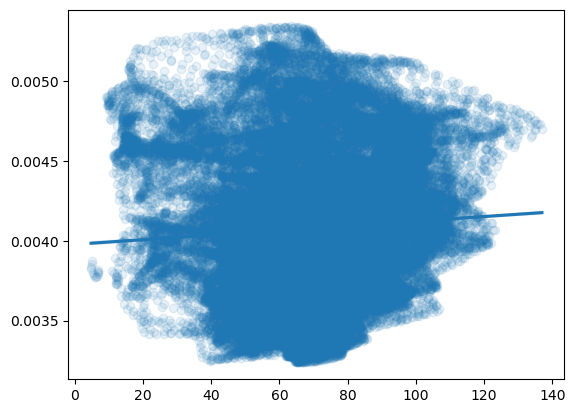

In [52]:
sns.regplot(
    x=np.array(cortical_connectome.sum(axis=0))[0],
    y=cortical_connectome_eigenvectors.T[0,],
    scatter_kws={'alpha': 0.1}
    # alpha=0.1,
)

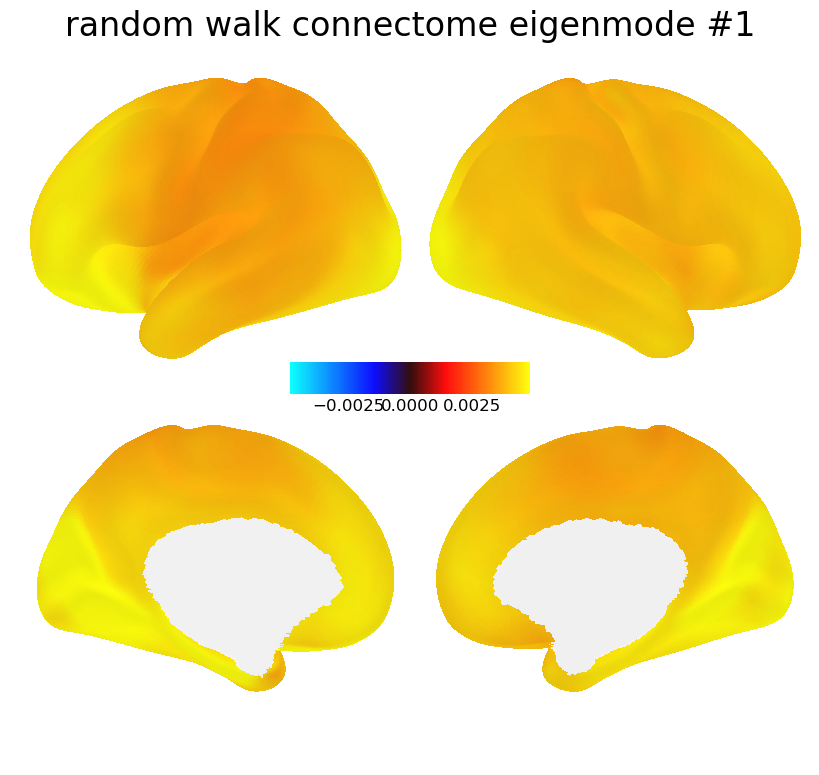

In [54]:
# data
eigenmode_idx = 0
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


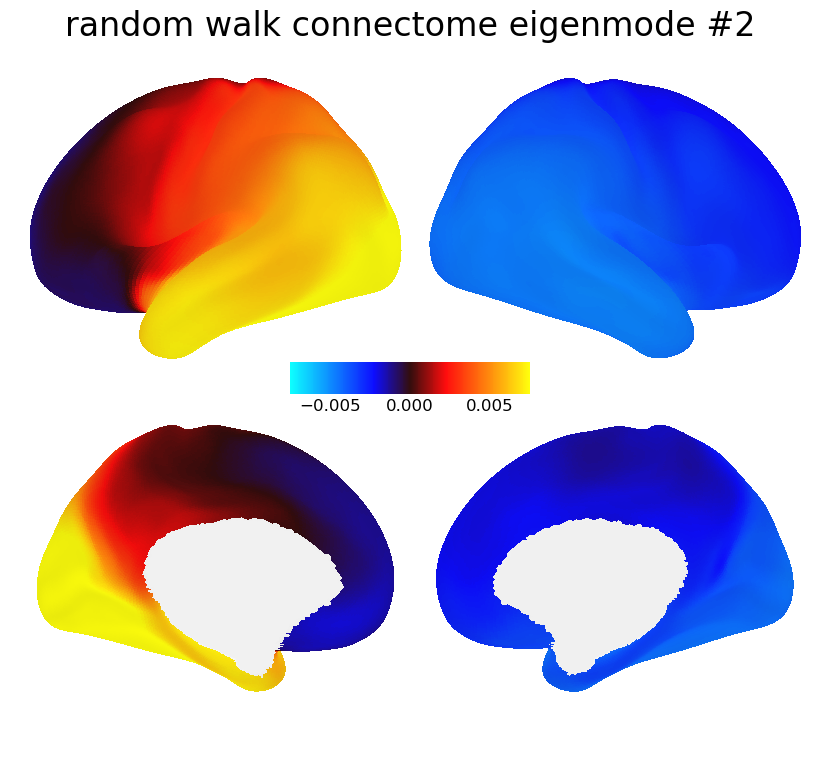

In [55]:
# data
eigenmode_idx = 1
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


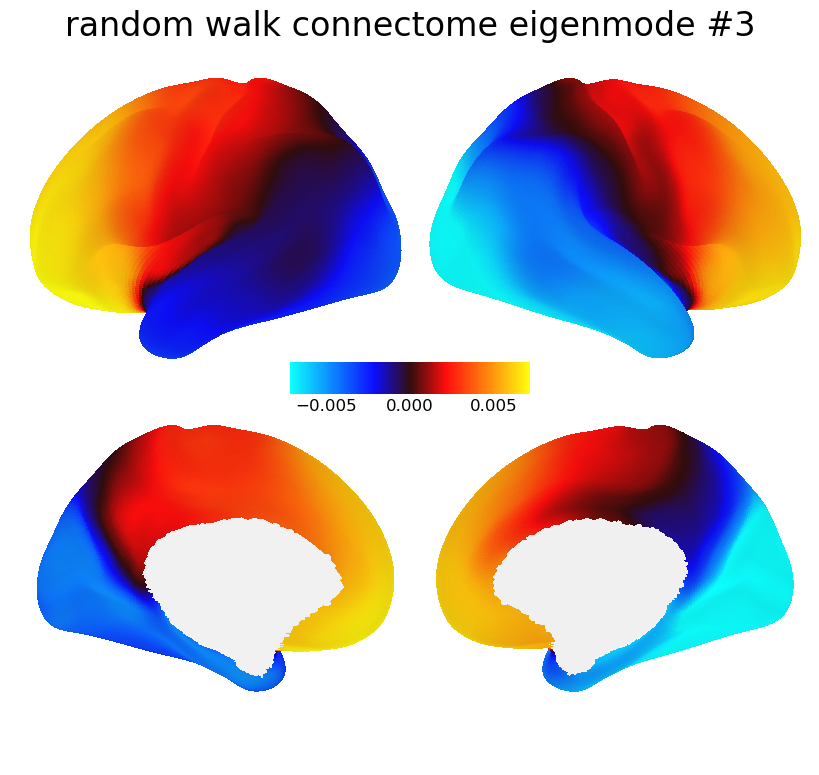

In [56]:
# data
eigenmode_idx = 2
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


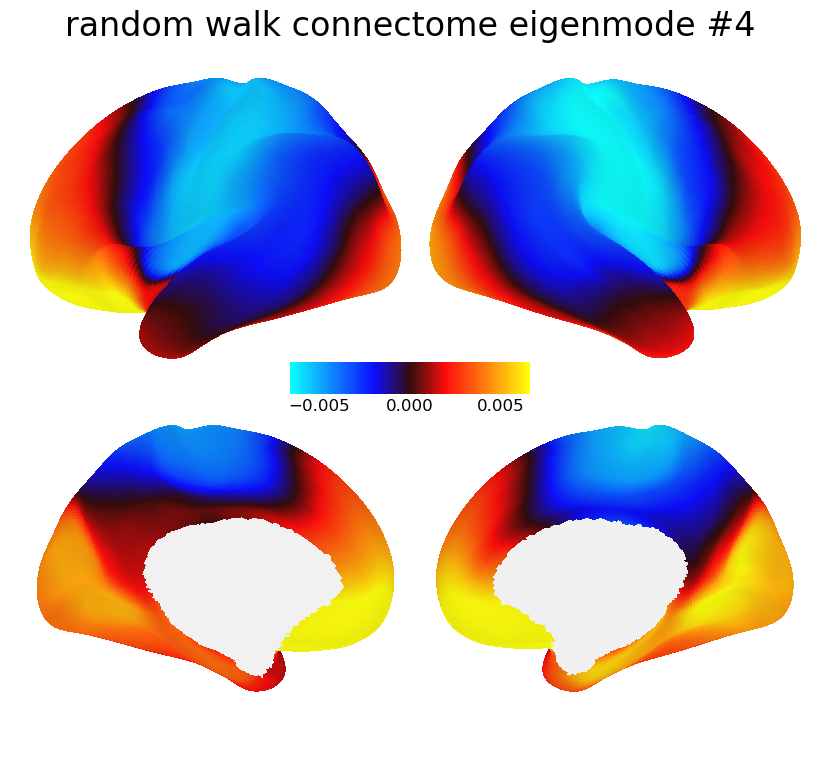

In [57]:
# data
eigenmode_idx = 3
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


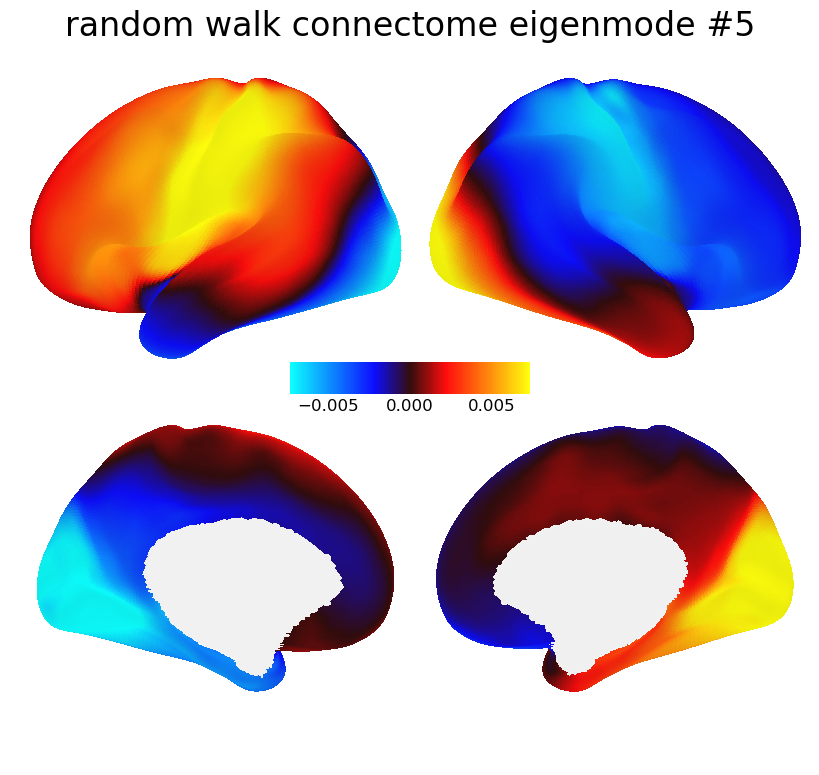

In [58]:
# data
eigenmode_idx = 4
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


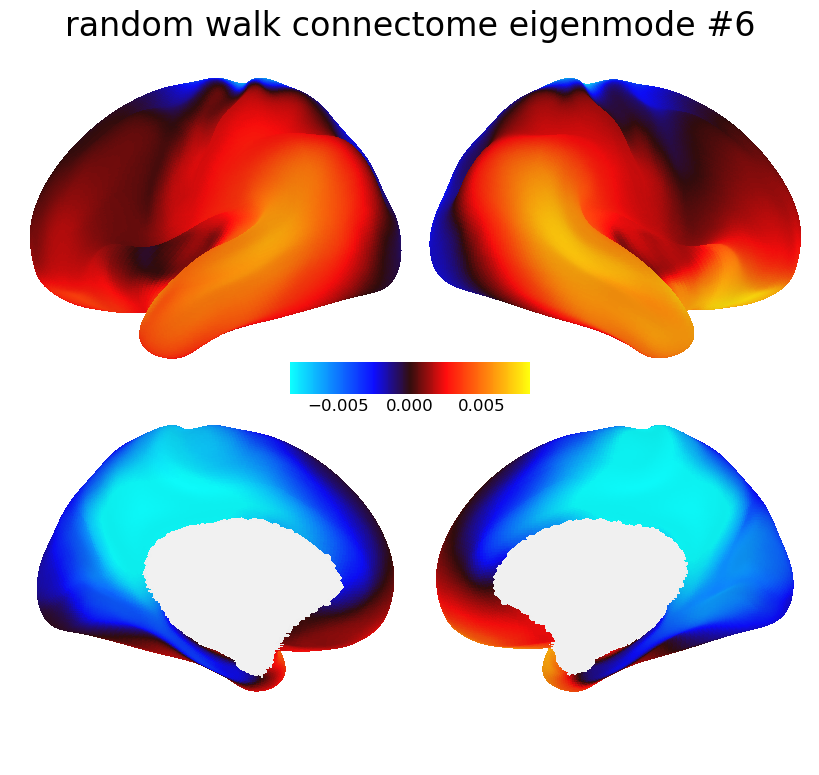

In [59]:
# data
eigenmode_idx = 5
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


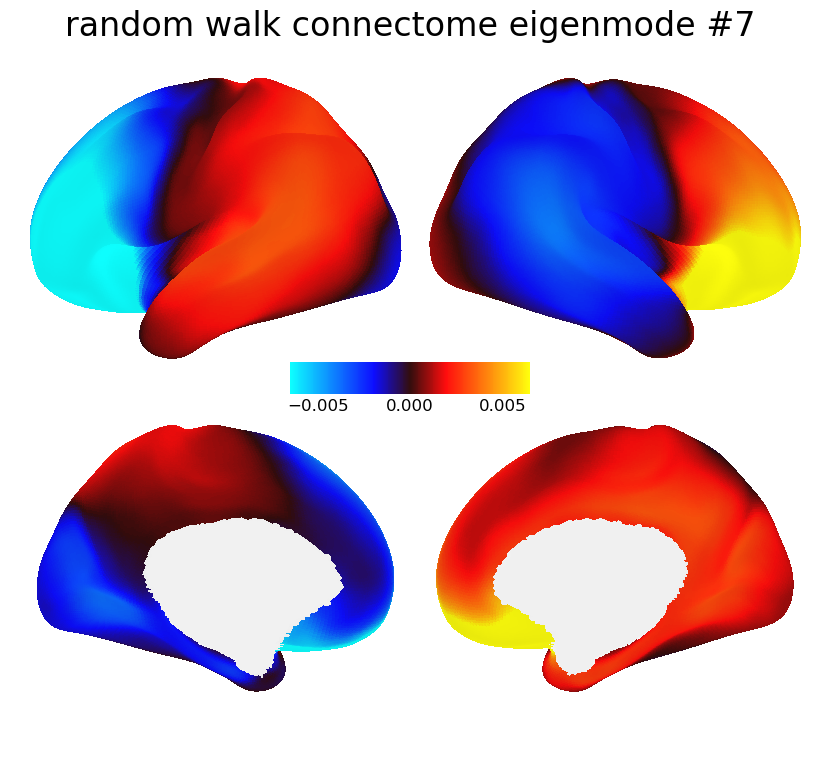

In [60]:
# data
eigenmode_idx = 6
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


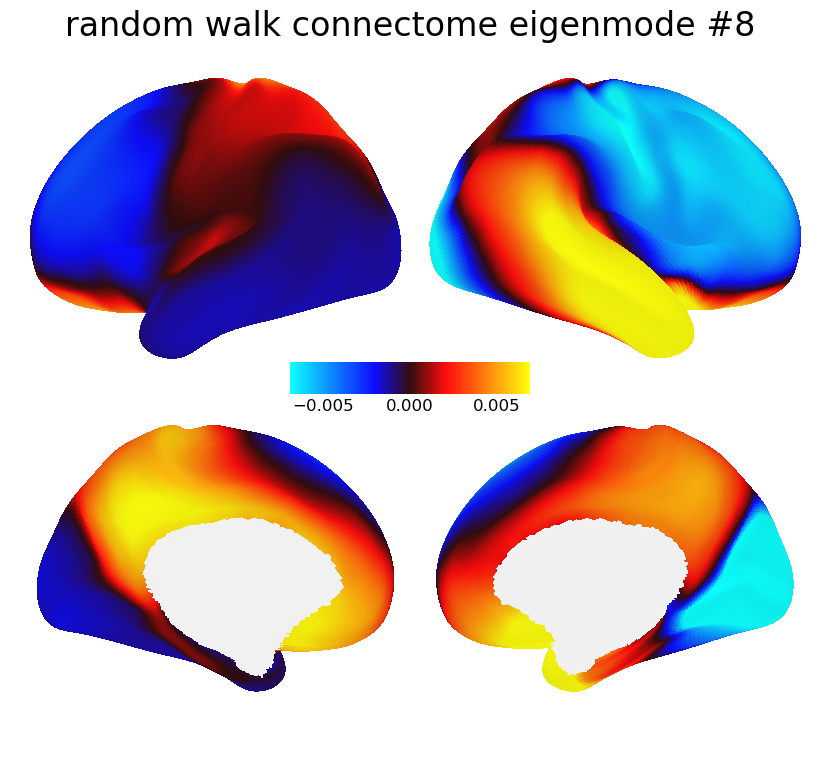

In [61]:
# data
eigenmode_idx = 7
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


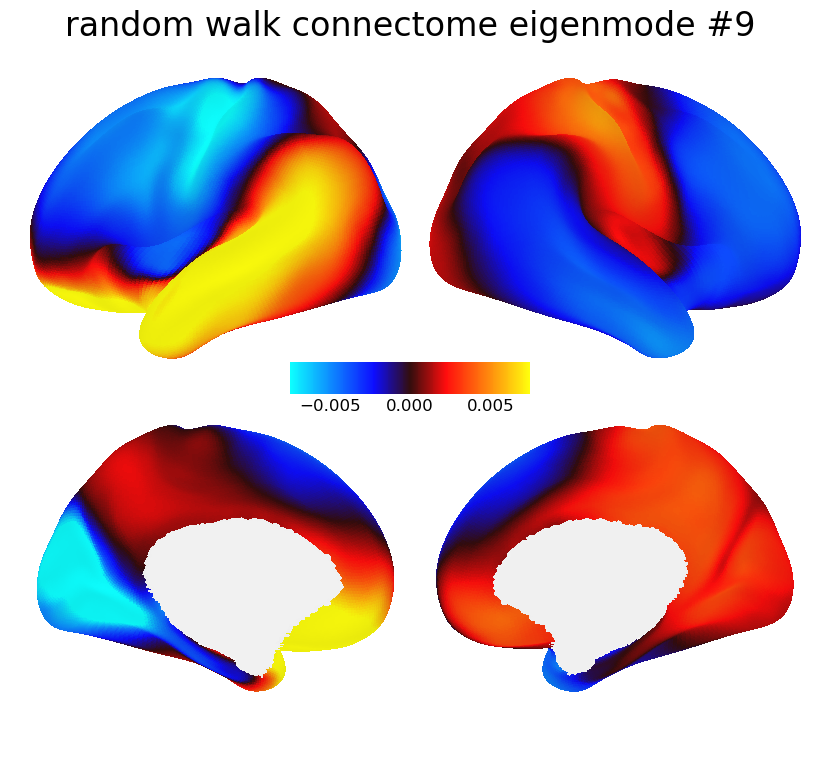

In [62]:
# data
eigenmode_idx = 8
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


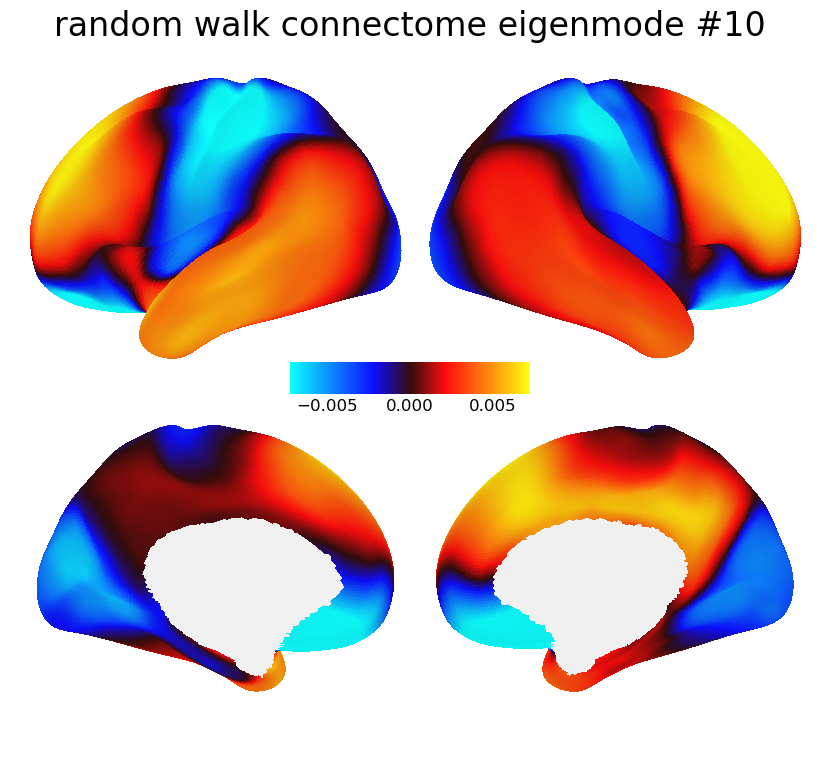

In [63]:
# data
eigenmode_idx = 9
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


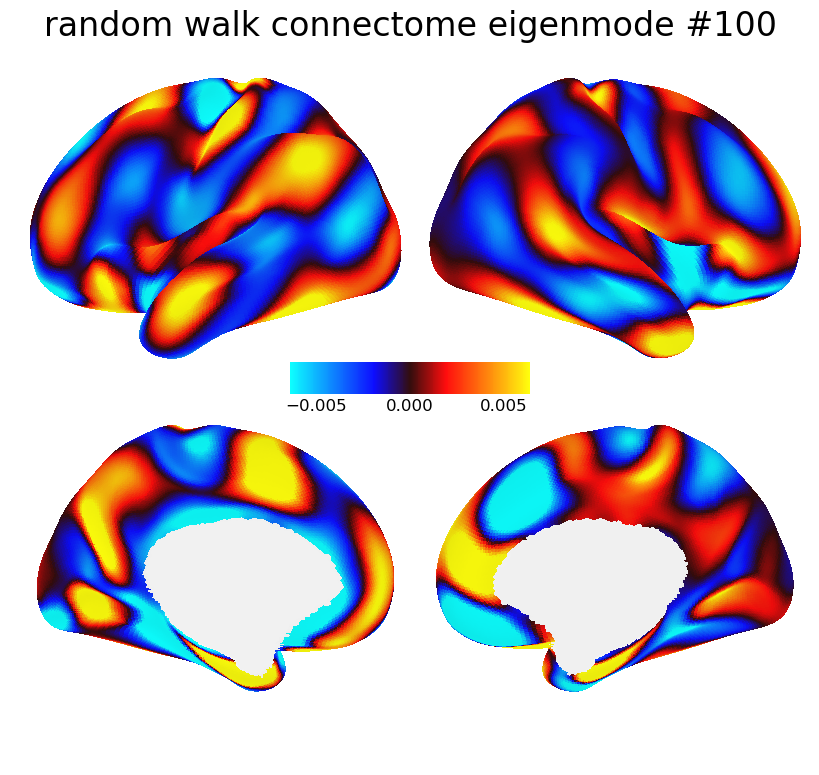

In [64]:
# data
eigenmode_idx = 99
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


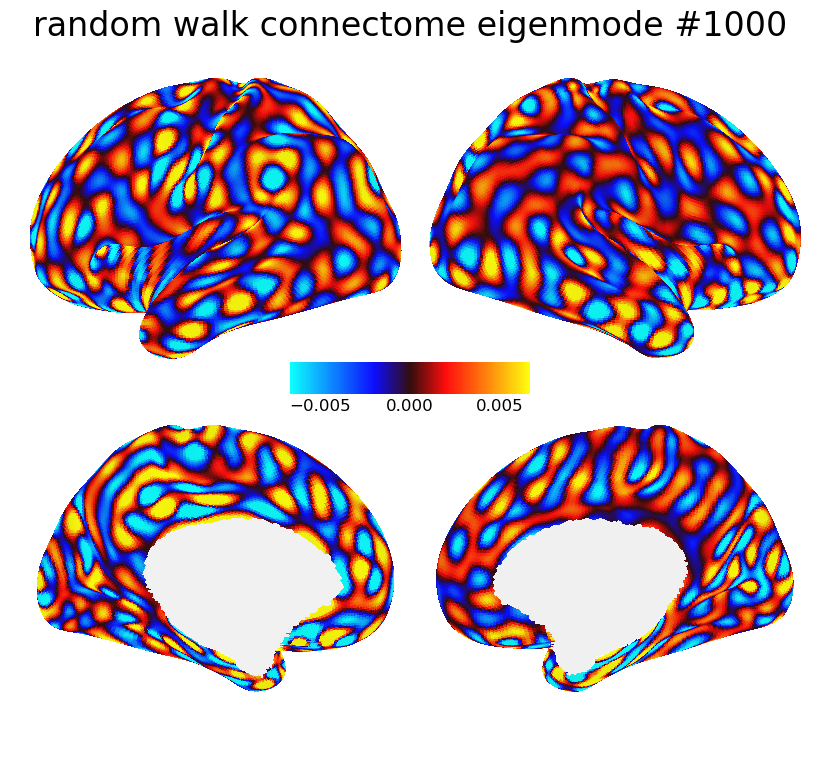

In [65]:
# data
eigenmode_idx = 999
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


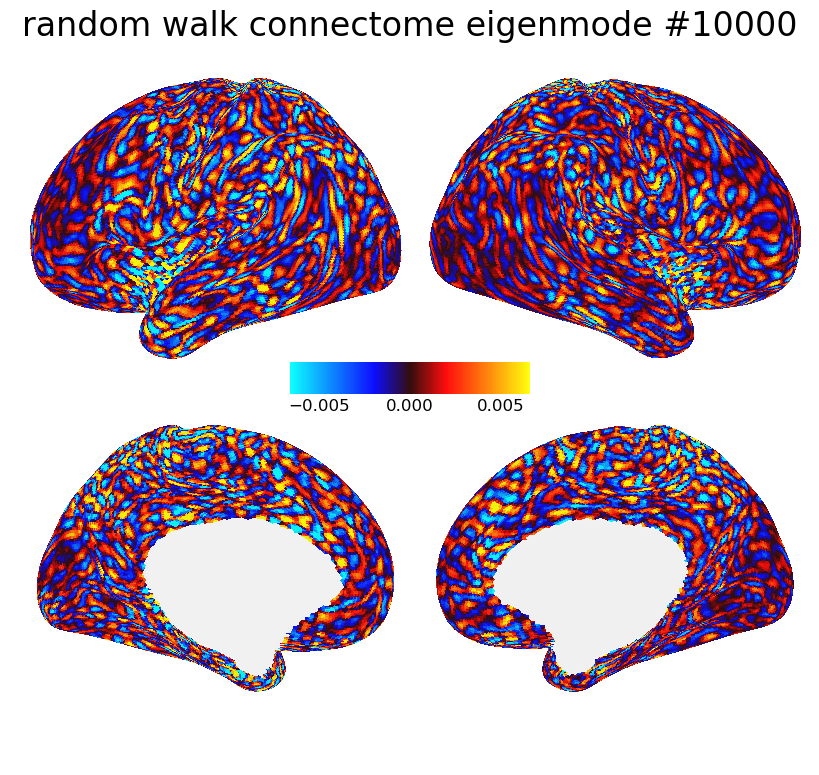

In [66]:
# data
eigenmode_idx = 9999
data = cortical_connectome_eigenvectors.T[eigenmode_idx,]

plot_data_on_brain_surface(
    data,
    title=f"random walk connectome eigenmode #{eigenmode_idx + 1}",
    symmetric_cbar=True, cmap=mycm_dark,
)


## Thickness encoding over kernel

---

In [67]:
all_thickness_data_encoded = np.dot(all_thickness_data, cortical_connectome_eigenvectors)
all_thickness_data_encoded.shape


(2473, 11001)

In [68]:
all_thickness_data_centered_encoded = np.dot(all_thickness_data - all_thickness_data.mean(), cortical_connectome_eigenvectors)
all_thickness_data_centered_encoded.shape


(2473, 11001)

## Kernel evaluations

---

In [69]:
# compute a measure of signal energy captured by each component
component_proportional_energy = np.power(all_thickness_data_encoded, 2).sum(0) / np.power(all_thickness_data, 2).sum()
component_proportional_energy_centered = np.power(all_thickness_data_centered_encoded, 2).sum(0) / np.power(all_thickness_data - all_thickness_data.mean(), 2).sum()


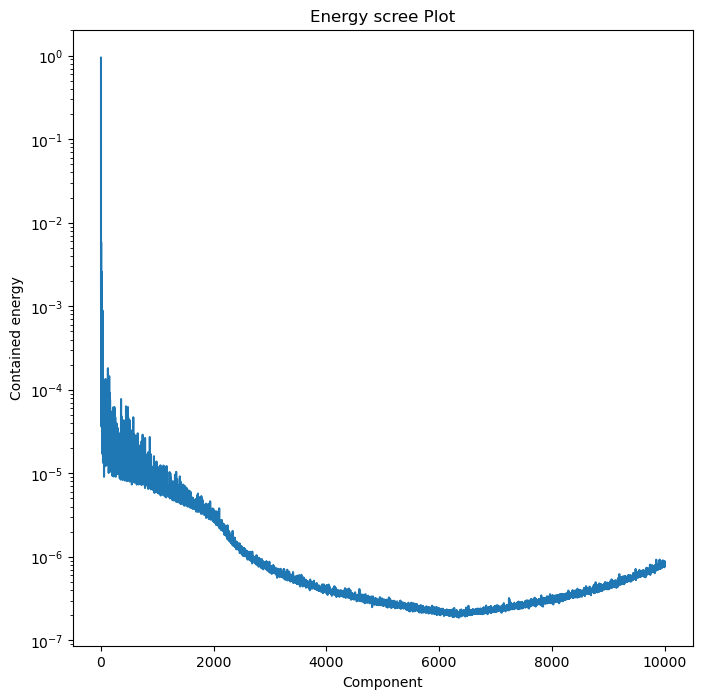

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 10000

axes.plot(
    np.arange(n_components) + 1,
    component_proportional_energy[:n_components],
)

axes.set_title('Energy scree Plot')
axes.set_xlabel('Component')
axes.set_ylabel('Contained energy')

axes.set_yscale('log')


Text(0, 0.5, 'Proportional energy')

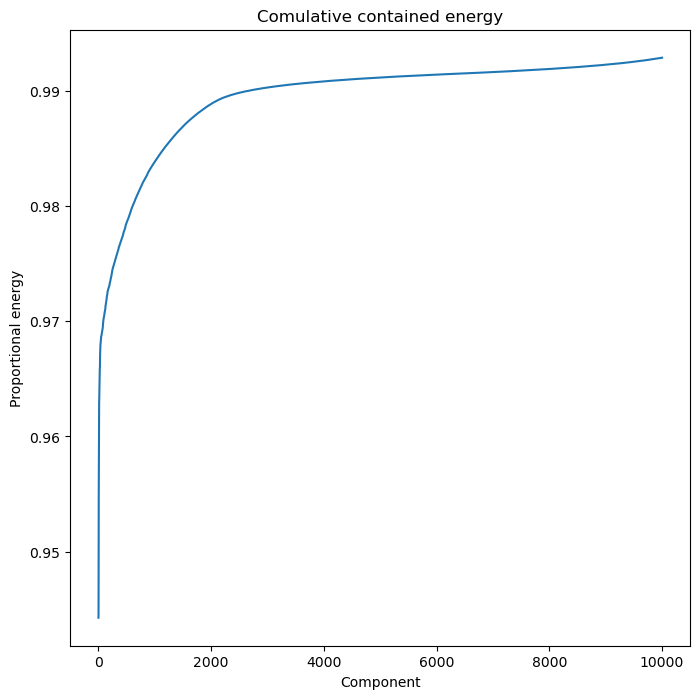

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 10000

axes.plot(
    np.arange(n_components) + 1,
    np.cumsum(component_proportional_energy[:n_components]),
)

axes.set_title('Comulative contained energy')
axes.set_xlabel('Component')
axes.set_ylabel('Proportional energy')

# axes.set_yscale('log')


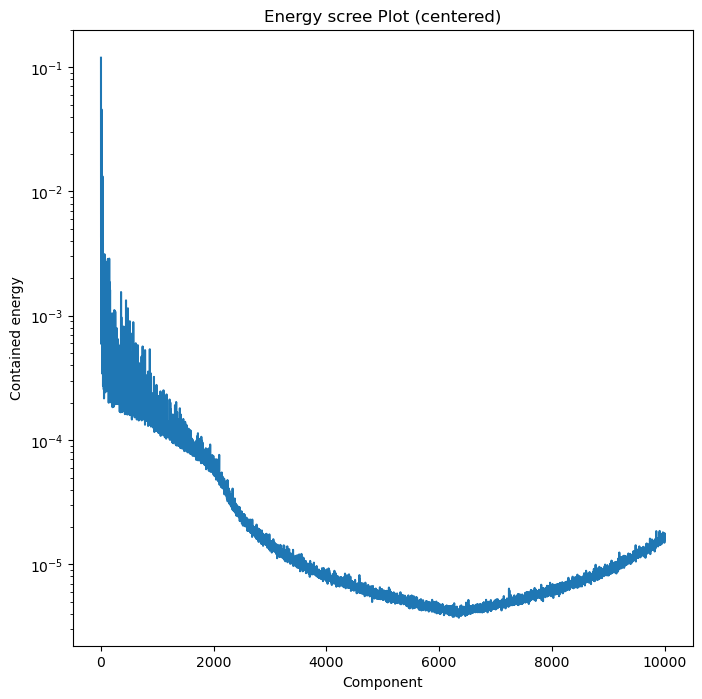

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 10000

axes.plot(
    np.arange(n_components) + 1,
    component_proportional_energy_centered[:n_components],
)

axes.set_title('Energy scree Plot (centered)')
axes.set_xlabel('Component')
axes.set_ylabel('Contained energy')

axes.set_yscale('log')


Text(0, 0.5, 'Proportional energy')

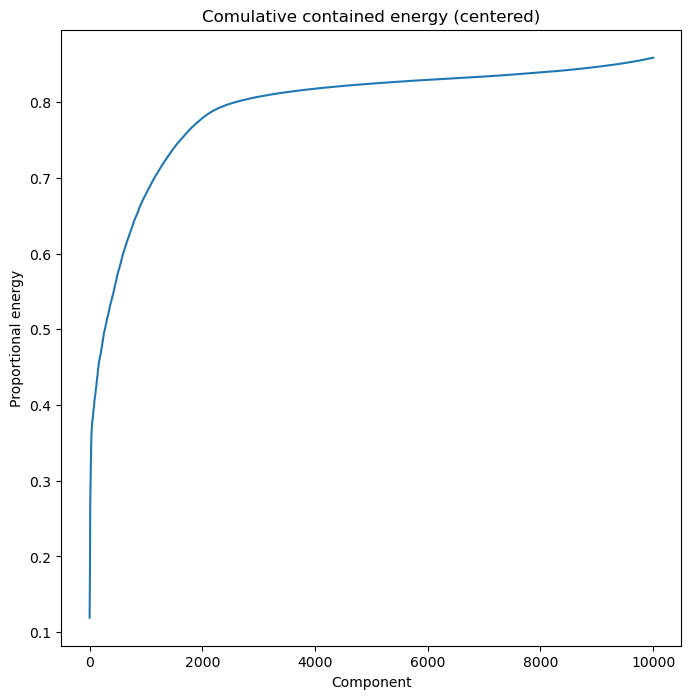

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# number of components to visualize
n_components = 10000

axes.plot(
    np.arange(n_components) + 1,
    np.cumsum(component_proportional_energy_centered[:n_components]),
)

axes.set_title('Comulative contained energy (centered)')
axes.set_xlabel('Component')
axes.set_ylabel('Proportional energy')

# axes.set_yscale('log')


## Asses the degree of independence across kernels

---


In [74]:
all_thickness_data_encoded.shape


(2473, 11001)

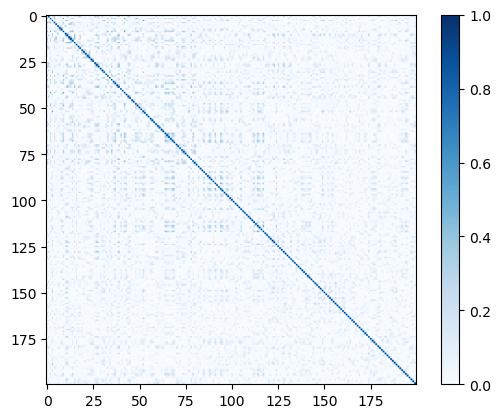

In [75]:
# compute covariance matrix (expected to be diagonal)
# np.cov(thickness_pca_encoded).shape
# np.cov(thickness_pca_encoded.T)
# plt.imshow(np.cov(thickness_pca_encoded.T[:100]), cmap=plt.cm.Blues, vmin=0, vmax=10)
shw = plt.imshow(np.corrcoef(all_thickness_data_encoded.T[:200]), cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
# plt.imshow(np.corrcoef(thickness_pca_encoded[:1000].T[:100]), cmap=plt.cm.Blues, vmin=0, vmax=1)


In [76]:
correlations = np.corrcoef(all_thickness_data_encoded.T)


Text(0.5, 1.0, 'Absolute correlation histogram')

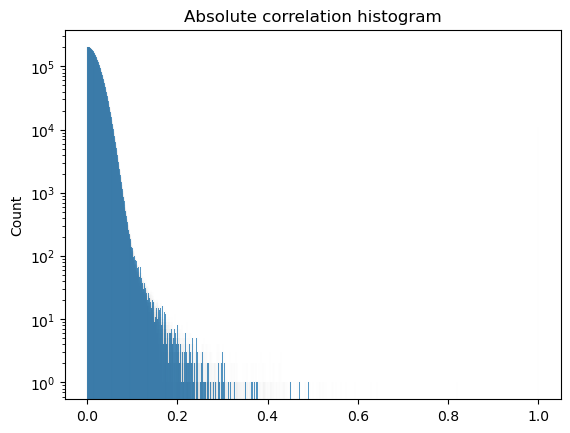

In [77]:
sns.histplot(np.abs(correlations)[np.triu_indices_from(correlations)], log_scale=(False, True))
plt.title('Absolute correlation histogram')


In [78]:
np.sum(np.abs(correlations)[np.triu_indices_from(correlations, k=1)] > 0.2)

2069

In [79]:
np.sum(np.abs(correlations)[np.triu_indices_from(correlations, k=1)] > 0.3)

378

As can be seen, while these components are by and large independent, there are cases where different components are in fact dependent and the covariance structure needs to be taken into account

## Accuracy of the mean thickness operation over kernel

---


In [80]:
# define the mean thickness operation
mean_thickness_vector = np.ones(cortical_connectome_eigenvectors.shape[0])

mean_thickness_vector_encoded = np.dot(mean_thickness_vector.reshape(1,-1), cortical_connectome_eigenvectors)


In [81]:
mean_thickness_vector_encoded.shape

(1, 11001)

In [82]:
# thickness_pca.inverse_transform(mean_thickness_vector_encoded)[0]
np.dot(mean_thickness_vector_encoded, cortical_connectome_eigenvectors.T)

array([[1.00008014, 1.0001676 , 1.00007662, ..., 0.9999537 , 1.00005762,
        1.00014223]])

In [86]:
# thickness_pca.inverse_transform(mean_thickness_vector_encoded)[0]
np.dot(mean_thickness_vector_encoded, cortical_connectome_eigenvectors.T).mean()

0.9999999881113842

<AxesSubplot: ylabel='Count'>

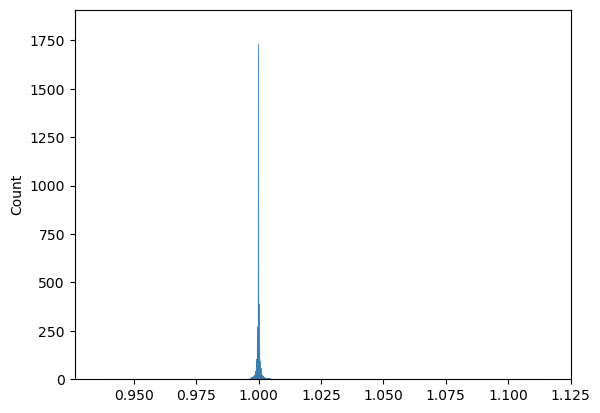

In [83]:
sns.histplot(np.dot(mean_thickness_vector_encoded[:,:10000], cortical_connectome_eigenvectors.T[:10000])[0])

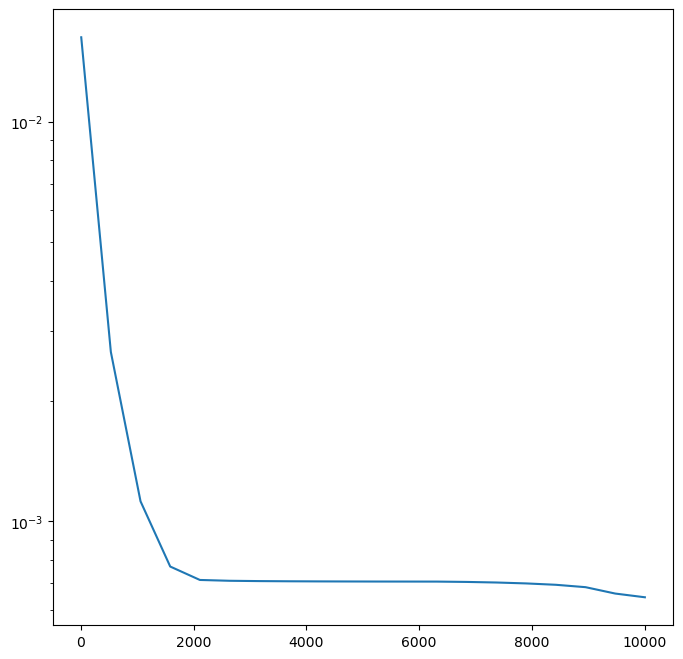

In [84]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.plot(
    np.linspace(10, 10000, 20, dtype=int),
    [
        np.mean(np.abs(1 - np.dot(mean_thickness_vector_encoded[:,:i], cortical_connectome_eigenvectors.T[:i])[0]))
        for i in np.linspace(10, 10000, 20, dtype=int)
    ]
)

axes.set_yscale('log')
# axes.set_xscale('log')


In [79]:
mean_thickness_vector

array([1., 1., 1., ..., 1., 1., 1.])

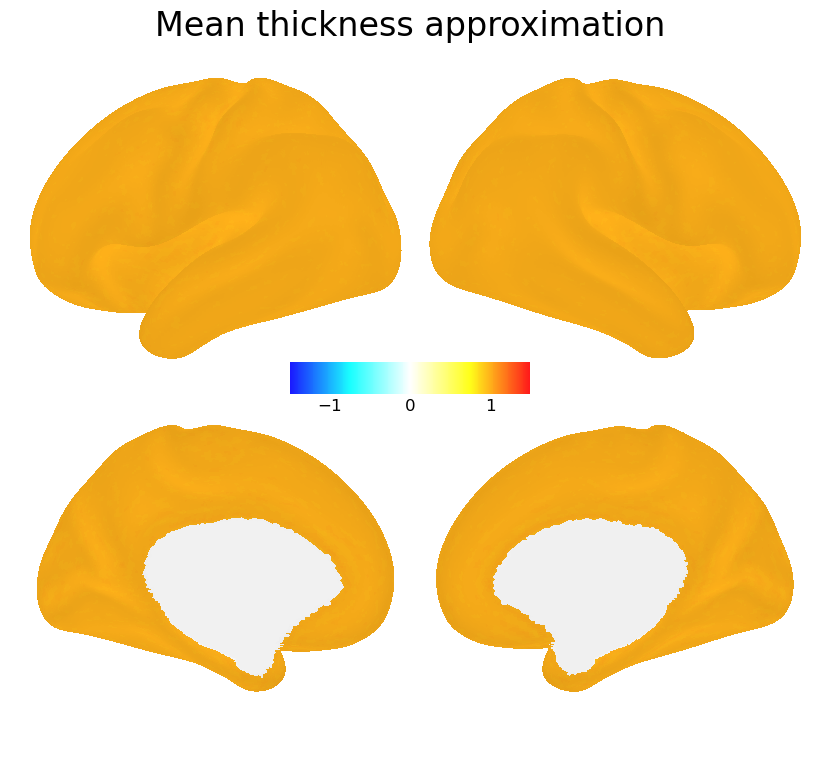

In [83]:
plot_data_on_brain_surface(
    np.dot(mean_thickness_vector_encoded, cortical_connectome_eigenvectors.T)[0],
    title=f"Mean thickness approximation",
    symmetric_cbar=True, vmax=1.5, vmin=0.,
)


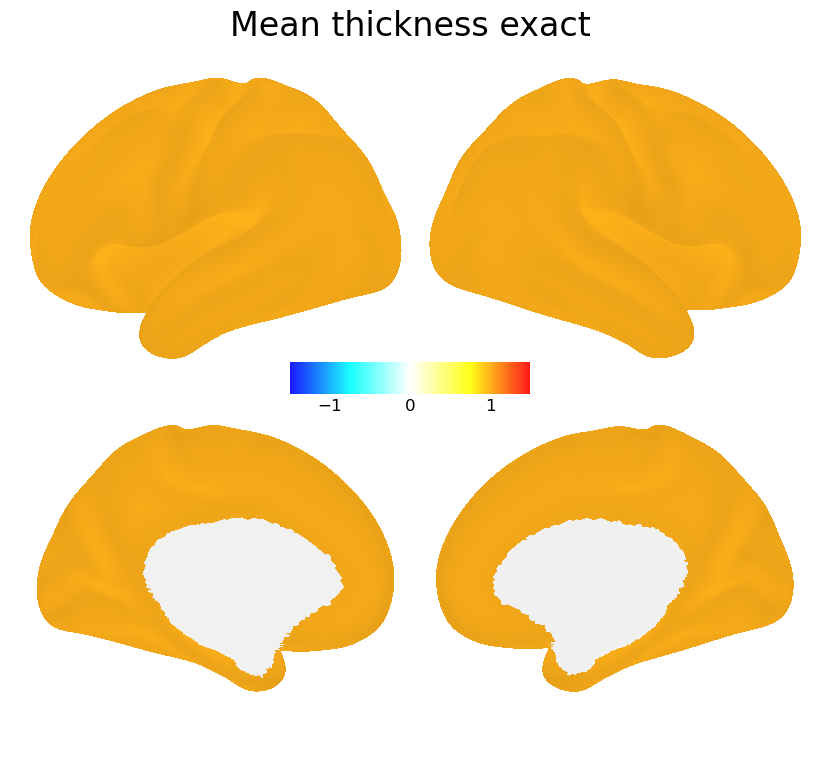

In [341]:
plot_data_on_brain_surface(
    mean_thickness_vector,
    title=f"Mean thickness exact",
    symmetric_cbar=True, vmax=1.5, vmin=0.,
)


Comparing connectome and CSS kernel's reconstruction power

In [85]:
from sklearn import metrics
mae = metrics.mean_absolute_error(mean_thickness_vector, np.dot(mean_thickness_vector_encoded[:,:2000], cortical_connectome_eigenvectors.T[:2000])[0])
print(f'Mean absolute error of approximation: {mae}')


Mean absolute error of approximation: 0.000717537804414466


In [85]:
from sklearn import metrics
mae = metrics.mean_absolute_error(mean_thickness_vector, np.dot(mean_thickness_vector_encoded[:,:2000], cortical_connectome_eigenvectors.T[:2000])[0])
print(f'Mean absolute error of approximation: {mae}')


Mean absolute error of approximation: 0.011950504063506513


In [92]:
from sklearn import metrics
mae = metrics.mean_absolute_error(mean_thickness_vector, np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0])
print(f'Mean absolute error of approximation: {mae}')


Mean absolute error of approximation: 0.0069950210355119785
